# Pandas Basics: Discovery → Cleaning → Quick Transforms

**Goal:** practice fast exploratory wrangling on a messy tabular dataset using Pandas.

**You’ll do:**
- Inspect structure and types
- Quantify missingness
- Handle missing values (drop / fill / interpolate)
- Lightweight transforms (casting, renaming, grouping, joining)
- Quick validation & export

## 1. Setup
---
**Goal:** Prepare your environment and load a dataset into Pandas.

**Steps:**
1. Import libraries: `pandas as pd`, `numpy as np`
2. Load your CSV into a DataFrame (`df`)

In [179]:
import os, sys, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Set paths
ROOT_ = os.getcwd()
DATA_  = os.path.join(ROOT_, "data")

# Obtain all CSV file paths in the data directory
csv_paths = glob.glob(os.path.join(DATA_, "*.csv*"))
assert len(csv_paths) > 0, f"No CSV files found in {DATA_}"

> 💡 "Data should be transformed as far upstream as possible, and as far downstream as necessary" - Matthew Roche, Microsoft

> Use `pd.read_csv(..., dtype=..., parse_dates=...)` to enforce schema at load time.



In [177]:
# -------------------------
#       LOADING DATA
# -------------------------

In [ ]:

# Load non-comma delimited data
data_name = "semicolon"
path = [path for path in csv_paths if data_name in path][0]
df_semicolon_delim = pd.read_csv(path)
print(df_semicolon_delim.head())

In [ ]:
# Load compressed data
data_name = "compressed"
path = [path for path in csv_paths if data_name in path][0]
df_compressed = pd.read_csv(path)   # Works because compression='infer' by default
print(df_compressed.head())

In [ ]:
# Load encoded data
data_name = "latin1"
path = [path for path in csv_paths if data_name in path][0]
df_encoded = pd.read_csv(path)
print(df_encoded.head())

In [ ]:
# Load data with metadata rows
data_name = "metadata"
path = [path for path in csv_paths if data_name in path][0]
df_metadata = pd.read_csv(path, skiprows=2, header=0)
print(df_metadata.head())

In [ ]:
# Load European date data
data_name = "dates1"
path = [path for path in csv_paths if data_name in path][0]
df_dayfirst = pd.read_csv(path)
print(df_dayfirst.head())

In [ ]:
# Load EU/US date data
data_name = "dates2"
path = [path for path in csv_paths if data_name in path][0]
df_dayfirst = pd.read_csv(path)
print(df_dayfirst.head(10))

# How do you decide if a number <= 12 is a month or a day?
# Without another column identifying region or prior information, we can't parse these correctly on read.

## 2. Discovery & Data Exploration
---
**Goal:** Get a first impression of the dataset’s structure and contents.**

**Core Functions:**
- `df.head()`, `df.tail()` → peek at rows
- `df.sample(5)` → random check
- `df.shape`, `df.dtypes`, `df.columns` → structure overview
- `df.info()` → column types + non-null counts
- `df.describe(include='all')` → quick summary (numeric + categorical)
- `df['col'].value_counts(dropna=False)` → frequency counts

> 📝 *Exercise*: Identify 3 columns that look suspicious (weird types, strange ranges, inconsistent categories).

In [180]:
# -------------------------
#   CREATING MESSY DATA
# -------------------------

# Set random seed for reproducibility
rng = np.random.default_rng(42)

# Generate a dataset with 500 rows and 5 features
n = 1000
age = rng.integers(15, 90, size=n).astype(float)  # numeric with some missing
income = rng.normal(50000, 15000, size=n)         # numeric with outliers
score = rng.uniform(0, 100, size=n)               # uniform, noise
signup_date = pd.date_range("2020-01-01", periods=n, freq="D")  # datetime
category = rng.choice(["A", "B", "C", None], size=n, p=[0.3, 0.3, 0.3, 0.1])  # categorical with NaNs

# Introduce missing values in age and income
age[rng.choice(n, 30, replace=False)] = np.nan
income[rng.choice(n, 20, replace=False)] = np.nan

# Add some extreme outliers in income
income[rng.choice(n, 5, replace=False)] = rng.normal(200000, 10000, size=5)

# Slightly corrupt score with negative and >100 values
score[rng.choice(n, 10, replace=False)] = rng.choice([-10, 150], size=10)

# Make signup_date strings with mixed separators
date_formats = ["%Y-%m-%d", "%Y/%m/%d", "%Y_%m_%d"]
signup_date_str = []
for i, dt in enumerate(signup_date):
    fmt = date_formats[i % len(date_formats)]
    signup_date_str.append(dt.strftime(fmt))

# Generate first and last names with inconsistencies
first_names = rng.choice(
    ["john", "ALICE", "Bob ", " mary", "N/A", None, "Eve", "steve", " Anna "],
    size=n
)
last_names = rng.choice(
    ["SMITH", "jones", "   DOE", "Brown", None, "Miller", "Wilson", "LEE", "N/A"],
    size=n
)

# Generate time column with constant format (e.g., "HH:MM")
times = pd.date_range("08:00", periods=n, freq="min")
time_str = [t.strftime("%H:%M") for t in times]

# Assemble DataFrame
df = pd.DataFrame({
    "first_name": first_names,
    "last_name": last_names,
    "age": age,
    "income": income,
    "score": score,
    "signup_date": signup_date_str,
    "signup_time": time_str,
    "category": category
})

# Introduce some duplicate rows
df = pd.concat([df, df.sample(10, random_state=42)], ignore_index=True)

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to CSV
df.to_csv(f"{DATA_}/trashy_dataset.csv", index=False)


In [181]:
# Load raw data
df_trashy_dataset = pd.read_csv(f"{DATA_}/trashy_dataset.csv")

# Print head and tail of the DataFrame
print(f"[DataFrame Head]\n")
print(df_trashy_dataset.head(10))

print(f"\n[DataFrame Tail]\n")
print(df_trashy_dataset.tail(10))

# Obtain a random sample from the DataFrame
print(f"\n[Random Sample of n Rows]\n")
print(df_trashy_dataset.sample(10))

[DataFrame Head]

  first_name last_name   age        income      score signup_date signup_time  \
0        NaN       LEE  42.0  72310.974345  65.622965  2021_09_21       18:29   
1       john    Wilson  55.0  58903.320424  89.812008  2022_02_27       21:08   
2        NaN       LEE  27.0  37087.374822  58.763497  2021-11-15       19:24   
3      Anna     Wilson  81.0  51817.669239   2.226882  2021-05-31       16:36   
4        Eve       NaN  84.0  31477.803696  98.764745  2021/06/13       16:49   
5       mary    Miller  62.0  48668.053284  25.672176  2021-10-19       18:57   
6      ALICE     SMITH  77.0  57277.416688  85.547536  2021-07-06       17:12   
7       john    Wilson  27.0  42488.828844  45.250793  2021-06-15       16:51   
8        NaN       LEE  23.0  55169.073571  15.428313  2020-11-17       13:21   
9      ALICE       NaN  74.0  58348.001641   5.794534  2020/03/11       09:10   

  category  
0        A  
1        A  
2        B  
3        A  
4        C  
5        A  

In [182]:
# Load raw data with some immediate cleaning
df_trashy_dataset = pd.read_csv(
    f"{DATA_}/trashy_dataset.csv",

    # Handle NA values
    na_values=["N/A", "NA", "None"],       # Treat these values as NaN
    keep_default_na=True,                  # Also keep pandas' default NA list
    
    # Strip extra spaces after delimiter
    skipinitialspace=True,                 

    # Handle duplicate header rows or bad lines
    on_bad_lines="skip",                   

    # Dtypes (optional, can enforce)
    dtype={"age": "float", "income": "float", "score": "float"},
)

In [183]:
# Print head and tail of the DataFrame
print(f"[DataFrame Head]\n")
print(df_trashy_dataset.head(10))

print(f"\n[DataFrame Tail]\n")
print(df_trashy_dataset.tail(10))

# Obtain a random sample from the DataFrame
print(f"\n[Random Sample of n Rows]\n")
print(df_trashy_dataset.sample(10))

[DataFrame Head]

  first_name last_name   age        income      score signup_date signup_time  \
0        NaN       LEE  42.0  72310.974345  65.622965  2021_09_21       18:29   
1       john    Wilson  55.0  58903.320424  89.812008  2022_02_27       21:08   
2        NaN       LEE  27.0  37087.374822  58.763497  2021-11-15       19:24   
3      Anna     Wilson  81.0  51817.669239   2.226882  2021-05-31       16:36   
4        Eve       NaN  84.0  31477.803696  98.764745  2021/06/13       16:49   
5       mary    Miller  62.0  48668.053284  25.672176  2021-10-19       18:57   
6      ALICE     SMITH  77.0  57277.416688  85.547536  2021-07-06       17:12   
7       john    Wilson  27.0  42488.828844  45.250793  2021-06-15       16:51   
8        NaN       LEE  23.0  55169.073571  15.428313  2020-11-17       13:21   
9      ALICE       NaN  74.0  58348.001641   5.794534  2020/03/11       09:10   

  category  
0        A  
1        A  
2        B  
3        A  
4        C  
5        A  

In [187]:
# View DataFrame shape, columns, and data types
print(f"\nDataFrame Shape: {df_trashy_dataset.shape}")
print(f"DataFrame Columns: {df_trashy_dataset.columns.tolist()}\n")
print(f"DataFrame Dtypes:\n {df_trashy_dataset.dtypes}")


DataFrame Shape: (1010, 8)
DataFrame Columns: ['first_name', 'last_name', 'age', 'income', 'score', 'signup_date', 'signup_time', 'category']

DataFrame Dtypes:
 first_name      object
last_name       object
age            float64
income         float64
score          float64
signup_date     object
signup_time     object
category        object
dtype: object


In [188]:
# Print DataFrame info to see data types and non-null counts
print(f"\n[DataFrame Info]\n")
print(df_trashy_dataset.info())


[DataFrame Info]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   first_name   786 non-null    object 
 1   last_name    764 non-null    object 
 2   age          980 non-null    float64
 3   income       988 non-null    float64
 4   score        1010 non-null   float64
 5   signup_date  1010 non-null   object 
 6   signup_time  1010 non-null   object 
 7   category     905 non-null    object 
dtypes: float64(3), object(5)
memory usage: 63.2+ KB
None


In [190]:
# Generate summary statistics for all columns:
# - For numeric columns:            count, mean, std, min, quartiles (25%, 50%, 75%), max
# - For object/categorical columns: count, unique, top (most frequent), freq (frequency of top)
# - For datetime columns:           count, unique, top, freq, first, last
df_trashy_dataset.describe(include='all')

,first_name,last_name,age,income,score,signup_date,signup_time,category
count,786,764,980.000000,988.000000,1010.000000,1010,1010,905
unique,7,7,NaN,NaN,NaN,1000,1000,3
top,mary,Wilson,NaN,NaN,NaN,2021-02-15,14:51,C
freq,126,128,NaN,NaN,NaN,2,2,307
mean,NaN,NaN,52.330612,50366.480115,50.233142,NaN,NaN,NaN
std,NaN,NaN,21.716082,18450.111946,30.125890,NaN,NaN,NaN
min,NaN,NaN,15.000000,-4726.192378,-10.000000,NaN,NaN,NaN
25%,NaN,NaN,33.000000,39702.761335,24.644544,NaN,NaN,NaN
50%,NaN,NaN,53.000000,50108.917304,49.378509,NaN,NaN,NaN
75%,NaN,NaN,72.000000,59599.615245,76.030798,NaN,NaN,NaN



Unique values in 'category' column:
income
NaN             22
15205.839099     2
43874.170591     2
69358.456435     2
38031.758546     2
                ..
37438.048939     1
45511.029442     1
56416.945974     1
71544.526348     1
51817.669239     1
Name: count, Length: 981, dtype: int64


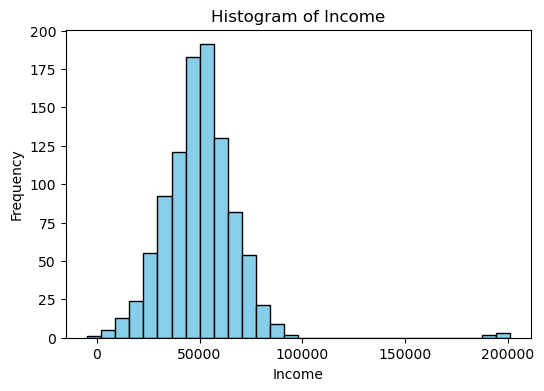

In [196]:
# Print unique values for a specific column and its value counts
column = 'income'
print(f"\nUnique values in 'category' column:\n{df_trashy_dataset[column].value_counts(dropna=False)}")

# Visualized
value_counts = df_trashy_dataset[column].value_counts(dropna=False)
if df_trashy_dataset[column].dtype == 'object':
    plt.figure(figsize=(6, 4))
    ax = value_counts.plot(kind='barh')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Value Counts for Category Column')
    plt.show()
else:
    plt.figure(figsize=(6, 4))
    ax = df_trashy_dataset[column].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
    plt.xlabel(column.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column.capitalize()}')
    plt.show()

In [197]:
# Identify duplicate rows and count them
duplicates = df_trashy_dataset.duplicated()
num_duplicates = duplicates.sum()

# Print duplicate rows
print(f"\nNumber of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print("\nDuplicate Rows:")
    print(df_trashy_dataset[duplicates])



Number of duplicate rows: 10

Duplicate Rows:
    first_name last_name   age        income      score signup_date  \
134        Eve     SMITH  54.0  28734.737448  66.292445  2021-11-09   
233       Bob     Wilson  32.0  43874.170591  77.664844  2021-02-15   
319      Anna        LEE  75.0  38031.758546  84.766647  2022/05/09   
522        NaN       NaN  25.0           NaN  63.235505  2021_06_05   
542        Eve       DOE  40.0  32069.615386   5.871868  2022_01_07   
565        NaN       NaN  60.0  53624.667825  84.667105  2020/05/16   
618       mary     jones  76.0           NaN  10.028740  2021-05-28   
640       john     Brown  28.0  15205.839099  96.759303  2021-10-22   
907        NaN       NaN  40.0  38081.008173  99.426918  2021_09_18   
949      Anna     Miller  76.0  69358.456435  98.671191  2022_01_10   

    signup_time category  
134       19:18      NaN  
233       14:51        B  
319       22:19        A  
522       16:41        C  
542       20:17        B  
565      

## 3. Missing Values
- Find: Count of missing values per column

**Strategies**
- Drop: `df.dropna(subset=[...])` when missingness is rare and random
- Fill constants: `df.fillna({'col': 0})`
- Fill by summary: mean/median/mode using `df['col'].fillna(df['col'].median())`


Missing values per column:
first_name     224
last_name      246
age             30
income          22
score            0
signup_date      0
signup_time      0
category       105
dtype: int64


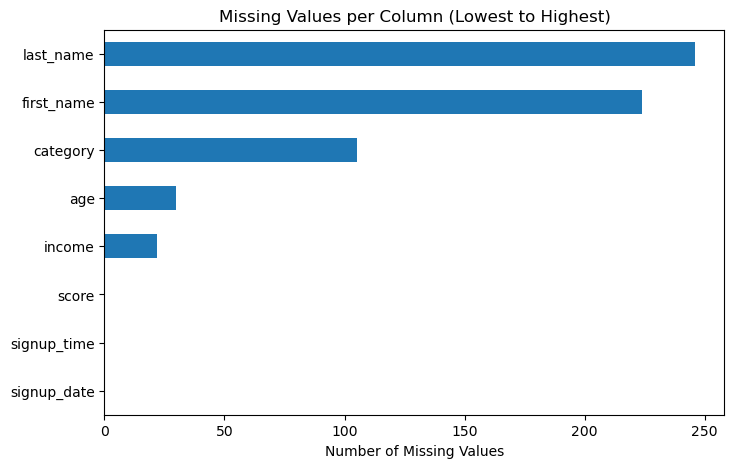

In [198]:
# Print count of missing values per column
print(f"\nMissing values per column:\n{df_trashy_dataset.isna().sum()}")

# Visualize missing values as a bar plot
missing_counts = df_trashy_dataset.isna().sum().sort_values()
plt.figure(figsize=(8, 5))
ax = missing_counts.plot(kind='barh')
plt.xlabel('Number of Missing Values')
plt.title('Missing Values per Column (Lowest to Highest)')
plt.show()

In [202]:
# -------------
#   FILL-NA
# -------------

# Fill missing values with column means (numeric) or mode (categorical)
df_fillna = df_trashy_dataset.copy()
before = df_fillna.loc[522]
print(df_fillna.describe(include='all'), end='\n\n')


# Criteria for filling in missing values for each column:
for col in df_fillna.columns:
    
    if df_fillna[col].dtype in [np.float64, np.int64]:          # Numeric Columns - Fill with Mean
        mean_value = df_fillna[col].mean()
        df_fillna[col] = df_fillna[col].fillna(mean_value)
        
    elif df_fillna[col].dtype == 'object':                      # Categorical Columns - Fill with most frequent (mode)
        mode_value = df_fillna[col].mode()[0]
        df_fillna[col] = df_fillna[col].fillna(mode_value)
        
    elif np.issubdtype(df_fillna[col].dtype, np.datetime64):    # Datetime Columns - Fill with most frequent (mode)
        mode_value = df_fillna[col].mode()[0]
        df_fillna[col] = df_fillna[col].fillna(mode_value)

# View summary statistics
df_fillna.info()

# View DataFrame after filling missing values
after = df_fillna.loc[522]
print(f"\n[Before FillNA]\n{before}\n")
print(f"\n[After FillNA]\n{after}\n")

       first_name last_name         age         income        score  \
count         786       764  980.000000     988.000000  1010.000000   
unique          7         7         NaN            NaN          NaN   
top          mary    Wilson         NaN            NaN          NaN   
freq          126       128         NaN            NaN          NaN   
mean          NaN       NaN   52.330612   50366.480115    50.233142   
std           NaN       NaN   21.716082   18450.111946    30.125890   
min           NaN       NaN   15.000000   -4726.192378   -10.000000   
25%           NaN       NaN   33.000000   39702.761335    24.644544   
50%           NaN       NaN   53.000000   50108.917304    49.378509   
75%           NaN       NaN   72.000000   59599.615245    76.030798   
max           NaN       NaN   89.000000  200895.089998   150.000000   

       signup_date signup_time category  
count         1010        1010      905  
unique        1000        1000        3  
top     2021-02-15   

In [205]:
# --------------------
#       DROP-NA
# --------------------

# Use dropna() to get rid of rows where any column is NaN/Null
df_dropna = df_trashy_dataset.copy()
df_dropna = df_dropna.dropna(how='any')

# View summary statistics
print(f'New Shape: {df_dropna.shape}\n')
df_dropna.info()

# Why do we see indexes 1-1008?

New Shape: (521, 8)

<class 'pandas.core.frame.DataFrame'>
Index: 521 entries, 1 to 1008
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   first_name   521 non-null    object 
 1   last_name    521 non-null    object 
 2   age          521 non-null    float64
 3   income       521 non-null    float64
 4   score        521 non-null    float64
 5   signup_date  521 non-null    object 
 6   signup_time  521 non-null    object 
 7   category     521 non-null    object 
dtypes: float64(3), object(5)
memory usage: 36.6+ KB


## 4. Quick Transformations
- Types: `df['col'] = df['col'].astype('Int64')`, `to_datetime`, `to_numeric(errors='coerce')`
- String cleanup: `str.strip()`, `str.lower()`, `str.replace()`
- Column ops: `rename`, `assign`, `eval`
- Split/merge: `merge`, `join`, `concat`


In [210]:
# Copying df_dropna
df_transformed = df_dropna.copy()
df_transformed.head()

,first_name,last_name,age,income,score,signup_date,signup_time,category
1,john,Wilson,55.0,58903.320424,89.812008,2022_02_27,21:08,A
3,Anna,Wilson,81.0,51817.669239,2.226882,2021-05-31,16:36,A
5,mary,Miller,62.0,48668.053284,25.672176,2021-10-19,18:57,A
6,ALICE,SMITH,77.0,57277.416688,85.547536,2021-07-06,17:12,C
7,john,Wilson,27.0,42488.828844,45.250793,2021-06-15,16:51,C


In [211]:
# Enforce column datatypes
df_transformed['first_name'] = df_transformed['first_name'].astype('string')
df_transformed['last_name'] = df_transformed['last_name'].astype('string')
df_transformed['age'] = df_transformed['age'].astype('int')

# Clean and standardize text columns
df_transformed['first_name'] = df_transformed['first_name'].str.strip().str.title()
df_transformed['last_name'] = df_transformed['last_name'].str.strip().str.title()

# Round income and score to 2 decimal places
df_transformed['income'] = df_transformed['income'].round(2)
df_transformed['score'] = df_transformed['score'].round(2)

df_transformed.head()

,first_name,last_name,age,income,score,signup_date,signup_time,category
1,John,Wilson,55,58903.32,89.81,2022_02_27,21:08,A
3,Anna,Wilson,81,51817.67,2.23,2021-05-31,16:36,A
5,Mary,Miller,62,48668.05,25.67,2021-10-19,18:57,A
6,Alice,Smith,77,57277.42,85.55,2021-07-06,17:12,C
7,John,Wilson,27,42488.83,45.25,2021-06-15,16:51,C


In [212]:
# Standardized date and time columns
# Use regex to replace non-digit characters with '-' before parsing
df_transformed["signup_date"] = df_transformed["signup_date"].str.replace(r"\D", "/", regex=True)
df_transformed["signup_date"] = pd.to_datetime(df_transformed["signup_date"], errors="coerce")

# Combine date and time into a single datetime column
df_transformed['signup_datetime'] = pd.to_datetime(
    df_transformed['signup_date'].astype(str) + ' ' + df_transformed['signup_time'], errors='coerce'
)

# Reorder columns
df_transformed = df_transformed[[
    'first_name', 'last_name', 'age', 'income', 'score',
    'signup_datetime', 'category'
]]    

# Rename income column to signify yearly income
df_transformed = df_transformed.rename(columns={'income': 'yearly_income'})


df_transformed.head()

,first_name,last_name,age,yearly_income,score,signup_datetime,category
1,John,Wilson,55,58903.32,89.81,2022-02-27 21:08:00,A
3,Anna,Wilson,81,51817.67,2.23,2021-05-31 16:36:00,A
5,Mary,Miller,62,48668.05,25.67,2021-10-19 18:57:00,A
6,Alice,Smith,77,57277.42,85.55,2021-07-06 17:12:00,C
7,John,Wilson,27,42488.83,45.25,2021-06-15 16:51:00,C


In [231]:
# Concatenate first and last names into a full_name column
df_transformed['full_name_normal'] = df_transformed['first_name'] + ' ' + df_transformed['last_name']
df_transformed['full_name_concat'] = pd.concat([df_transformed['first_name'], df_transformed['last_name']], axis=1).agg(' '.join, axis=1)
print(df_transformed.head())

# Drop the full_name columns
df_transformed = df_transformed.drop(columns=['full_name_normal', 'full_name_concat'])
print(df_transformed.head())

  first_name last_name  age  yearly_income  score     signup_datetime  \
1       John    Wilson   55       58903.32  89.81 2022-02-27 21:08:00   
3       Anna    Wilson   81       51817.67   2.23 2021-05-31 16:36:00   
5       Mary    Miller   62       48668.05  25.67 2021-10-19 18:57:00   
6      Alice     Smith   77       57277.42  85.55 2021-07-06 17:12:00   
7       John    Wilson   27       42488.83  45.25 2021-06-15 16:51:00   

  category full_name_normal full_name_concat  
1        A      John Wilson      John Wilson  
3        A      Anna Wilson      Anna Wilson  
5        A      Mary Miller      Mary Miller  
6        C      Alice Smith      Alice Smith  
7        C      John Wilson      John Wilson  
  first_name last_name  age  yearly_income  score     signup_datetime category
1       John    Wilson   55       58903.32  89.81 2022-02-27 21:08:00        A
3       Anna    Wilson   81       51817.67   2.23 2021-05-31 16:36:00        A
5       Mary    Miller   62       48668.05

In [ ]:
# --------------------
#      MERGE/JOIN
# --------------------
# Create two DataFrames with a common key column 'id'
id      = [111, 112, 113, 114, 115, 116]
person  = ['a', 'b', 'c', 'd', 'e', 'f']
age     = [23, 45, 12, 36, 28, 40]

df1 = pd.DataFrame({
    'id': id,
    'person': person
})
df2 = pd.DataFrame({
    'id': id,
    'age': age
})

# Merge the two DataFrames on the 'id' column using an inner join
df_inner_joined = pd.merge(df1, df2, on='id', how='inner')
df_inner_joined.head()


,id,person,age
0,111,a,23
1,112,b,45
2,113,c,12
3,114,d,36
4,115,e,28


## 5. Validations (cheap but effective)
- Range checks: `(df['age']>=0) & (df['age']<=120)`
- Cross-field rules: if `end_time` then `end_time>=start_time`
- Uniqueness: `df['id'].is_unique`
- Duplicates: `df.duplicated(subset=[...], keep=False)` then review

In [227]:
# Check for any unrealistic ages
invalid_ages = (df_transformed['age'] < 0) | (df_transformed['age'] > 120)
num_invalid_ages = invalid_ages.sum()
print(f"Number of invalid ages: {num_invalid_ages}")

# Check for negative values in all columns
for col in df_transformed.columns:
    if df_transformed[col].dtype in [np.float64, np.int64]:
        num_negatives = (df_transformed[col] < 0).sum()
        if num_negatives > 0:
            print(f"Column '{col}' has {num_negatives} negative values.")

# Check again for duplicates after dropna()
duplicates = df_transformed.duplicated()
num_duplicates = duplicates.sum()
print(f"\nNumber of duplicate rows after dropna(): {num_duplicates}")
if num_duplicates > 0:
    print("\nDuplicate Rows:")
    print(df_transformed[duplicates])
    
    df_transformed = df_transformed.drop_duplicates()

duplicates = df_transformed.duplicated()
num_duplicates = duplicates.sum()
print(f"\nNumber of duplicate rows after dropna() and drop_duplicates(): {num_duplicates}")

# Check for any remaining missing values or NaTs
print(f"\nMissing values per column after dropna():\n{df_transformed.isna().sum()}")


Number of invalid ages: 0
Column 'yearly_income' has 1 negative values.
Column 'score' has 3 negative values.

Number of duplicate rows after dropna(): 5

Duplicate Rows:
    first_name last_name  age  yearly_income  score     signup_datetime  \
233        Bob    Wilson   32       43874.17  77.66 2021-02-15 14:51:00   
319       Anna       Lee   75       38031.76  84.77 2022-05-09 22:19:00   
542        Eve       Doe   40       32069.62   5.87 2022-01-07 20:17:00   
640       John     Brown   28       15205.84  96.76 2021-10-22 19:00:00   
949       Anna    Miller   76       69358.46  98.67 2022-01-10 20:20:00   

    category    full_name full_name_normal full_name_concat  
233        B   Bob Wilson       Bob Wilson       Bob Wilson  
319        A     Anna Lee         Anna Lee         Anna Lee  
542        B      Eve Doe          Eve Doe          Eve Doe  
640        A   John Brown       John Brown       John Brown  
949        C  Anna Miller      Anna Miller      Anna Miller  

Numbe

## 6. Export
- Save a clean slice: `df.to_parquet('clean.parquet', index=False)` or `to_csv`

**Takeaways**
- Start with discovery, not modeling.
- Make missingness visible first, then pick the simplest plausible fix.
- Encode your checks so you can re-run them later.

In [228]:
# Save the cleaned dataset to a csv
cleaned_dataset = f"{DATA_}/cleaned_dataset.csv"
df_transformed.to_csv(cleaned_dataset, index=False)